# **Esercitazione 1**
## Agenti Intelligenti


In [2]:
### Requirements se eseguite in locale:
### python3 >= 3.7
### pygame >= 2.3.0

### Io utilizzo python 3.10.13 e pygame 2.5.2

## **Setup**: GridWorld

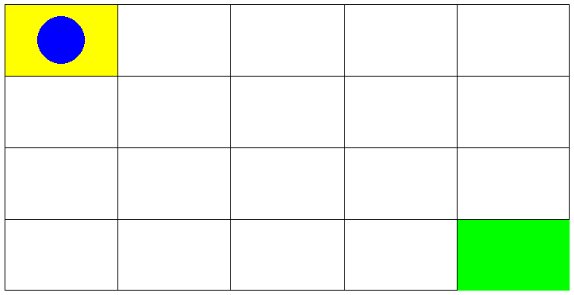


* ##    **goal**: raggiungere la cella in basso a destra (4,3) partendo dalla cella in alto a sinistra (0,0)
* ##   **azioni**: “N”, “S”, “E”, “W”, None
* ##   **osservabili**: x, y, x_max, y_max
* ##   **misura di performance**: numero di step necessari (da minimizzare)

### Creiamo il nostro GridWorld

In [1]:
# Implementation (grid world, rendering, main)
import pygame
import sys

class GridWorld:
    def __init__(
            self,
            x_max,
            y_max,
            x_green,
            y_green,
            x_gray,
            y_gray,
            agent,
            omniscent, # whether the agent is also passed x_green and y_green
            forbidden,
    ) -> None:
        self.x_max = x_max
        self.y_max = y_max
        self.x_green = x_green
        self.y_green = y_green
        self.x_gray = x_gray
        self.y_gray = y_gray
        self.agent = agent
        self.omniscent = omniscent
        self.forbidden = forbidden
        self.x_agent = self.y_agent = 0
        self.success = False

    def transition(self, x, y, action) -> tuple:
        if action is None:
            return x, y
        if action in self.forbidden:
            print(F'warning: forbidden "{action}" ignored!')
            return x, y
        dx, dy = 0, 0
        if action.startswith('N'):
            dy = -1
        elif action.startswith('S'):
            dy = +1
        if action.endswith('E'):
            dx = +1
        elif action.endswith('W'):
            dx = -1
        x1 = max(0, min(self.x_max, x + dx))
        y1 = max(0, min(self.y_max, y + dy))
        invalid = False
        # invalid if crossing a wall
        invalid |= dx != 0 and x1 == x
        invalid |= dy != 0 and y1 == y
        # invalid if trying to get to the gray cell
        invalid |= self.x_gray is not None and x1 == self.x_gray and y1 == self.y_gray
        if invalid:
            # restore previous position
            x1, y1 = x, y
        return x1, y1

    def model(self, state, action):
        x, y = state["x"], state["y"]
        return self.transition(x, y, action)

    def step(self) -> None:
        #print(f'[env] invoking agent s_agent=({self.x_agent},{self.y_agent})...')
        if self.omniscent:
            action = self.agent(self.x_agent, self.y_agent, self.x_max, self.y_max)
        else:
            action = self.agent(self.x_agent, self.y_agent)
        #print(f'[env] s_agent=({self.x_agent},{self.y_agent}), received action: {action}')
        print(f'[env] received action: {action}, agent position was: {(self.x_agent,self.y_agent)}')
        if (self.x_agent, self.y_agent) == (self.x_green, self.y_green):
            self.success = True
        else:
            self.x_agent, self.y_agent = self.transition(self.x_agent, self.y_agent, action)

    def render(self, screen: pygame.Surface) -> None:
        w, h = screen.get_width(), screen.get_height()
        grid_width = self.x_max + 1
        grid_height = self.y_max + 1
        padding_cells = 1
        cell_width = w / (2*padding_cells + grid_width)
        cell_height = h / (2*padding_cells + grid_height)
        x_pad, y_pad = cell_width*padding_cells, cell_height*padding_cells
        agent_size = goal_size = (2/3)*min(cell_height, cell_width)
        # clear the screen
        screen.fill("white")
        # draw the grid borders
        pygame.draw.rect(
            screen,
            color="black",
            rect=pygame.Rect(x_pad, y_pad, cell_width*grid_width, cell_height*grid_height),
            width=1,
        )
        # draw cell borders
        for i in range(grid_width-1):
            pygame.draw.line(
                screen,
                color="black",
                start_pos=[x_pad + (i+1)*cell_width, y_pad],
                end_pos=[x_pad + (i+1)*cell_width, y_pad + grid_height*cell_height - 1]
            )
        for i in range(grid_height-1):
            pygame.draw.line(
                screen,
                color="black",
                start_pos=[x_pad, y_pad + (i+1)*cell_height],
                end_pos=[x_pad + grid_width*cell_width - 1, y_pad + (i+1)*cell_height]
            )
        # draw the gray cell
        if self.x_gray is not None:
            
            pygame.draw.rect(
                screen,
                color="gray",
                rect=pygame.Rect(
                    1 + x_pad + self.x_gray*cell_width,
                    1 + y_pad + self.y_gray*cell_height,
                    cell_width - 1,
                    cell_height - 1
                )
            )
        # draw the start cell
        pygame.draw.rect(
            screen,
            color="yellow",
            rect=pygame.Rect(
                    1 + x_pad,
                    1 + y_pad,
                    cell_width - 1,
                    cell_height - 1
            )
        )
        # draw the goal cell
        pygame.draw.rect(
            screen,
            color="green",
            rect=pygame.Rect(
                    1 + x_pad + self.x_green*cell_width,
                    1 + y_pad + self.y_green*cell_height,
                    cell_width - 1,
                    cell_height - 1
            )
        )
        # draw the agent
        x_agent_screen = cell_width/2 + (padding_cells + self.x_agent)*cell_width
        y_agent_screen = cell_height/2 + (padding_cells + self.y_agent)*cell_height
        pygame.draw.circle(
            screen,
            color="blue",
            center=[x_agent_screen, y_agent_screen],
            radius=agent_size/2,
        )

pygame 2.5.2 (SDL 2.28.3, Python 3.12.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Codice per visualizzare l'agente che si muove nel mondo

In [2]:
def run_env(env):
    # pygame setup
    pygame.init()
    screen = pygame.display.set_mode((1280, 720))
    clock = pygame.time.Clock()
    running = True
    frames_per_step = 50 # determines speed of rendering
    frames = 1
    env.render(screen=screen)

    while running and not env.success:
        # poll for events
        # pygame.QUIT event means the user clicked X to close your window
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # advance world by one time step and render it to screen
        if frames % frames_per_step == 0:
            env.step()
            env.render(screen=screen)
        frames += 1

        # flip() the display to put your work on screen
        pygame.display.flip()

        clock.tick(60)  # limits FPS to 60

    pygame.quit()


    if env.success:
        print(f'The agent reached the goal successfully!')
    else:
        print(f"The agent did NOT reach the goal.")
    

## **Esercizio 1**:
### Risolvere l'ambiente con un **agente reattivo semplice** (completare codice)
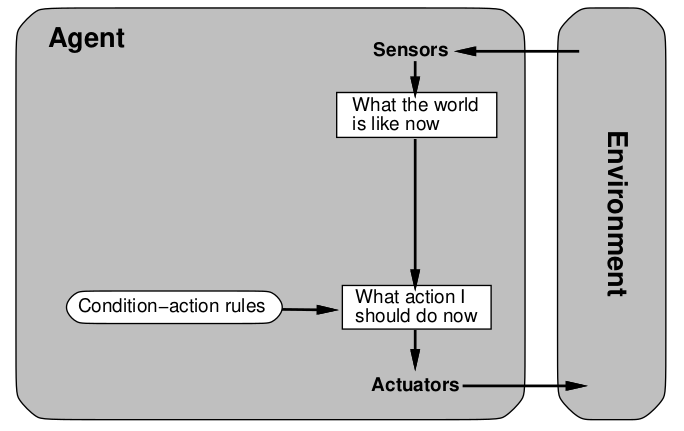

In [5]:
def simple_reflex_action(x, y, x_max, y_max):
    if x < x_max:
        return "E"
    if y < y_max:
        return "S"


In [4]:
env = GridWorld(
    x_max=4,
    y_max=3,
    x_green=4,
    y_green=3,
    x_gray=None,
    y_gray=None,
    agent=simple_reflex_action,
    omniscent=True,
    forbidden=["NE", "NW", "SE", "SW"]
)
print(f'Running es 1...')
run_env(env)

NameError: name 'simple_reflex_action' is not defined

## **Esercizio 2**:
### Questa volta assumiamo che x_max e y_max NON SONO OSSERVABILI
### A) Risolvere l'ambiente con un **agente reattivo model-based** (completare codice)

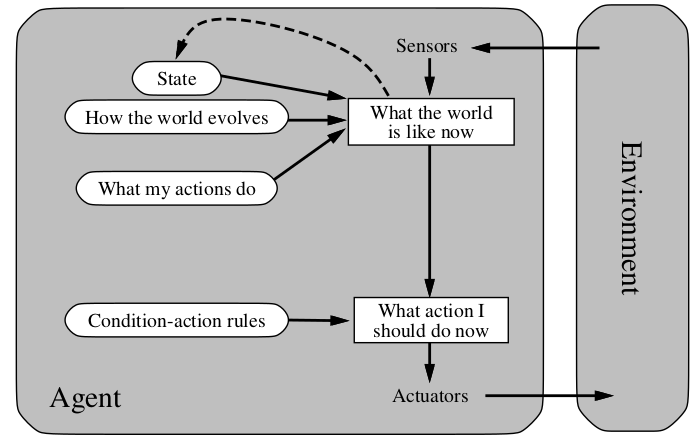

In [6]:
# Note:
# - state è un dict che contiene le key "x", "y", "x_max", "y_max"
# - state["x_max"] e state["y_max"] sono inizialmente None (ignoti)
# - model è una funzione tale che model(state, action) "predice" la
#   prossima posizione (x, y) dell'agente, assumendo che parta da
#   state e segua l'azione action (considerando anche i limiti della
#   griglia)

#Mi serve per trovare x_max e y_max
def update_state(state, last_action, x, y, model):
    state["x"], state["y"] = x, y
    # da completare: aggiornare state["x_max"] e state["y_max"]
    x_pred, y_pred = model(state, last_action)
    #Sto rimanendo sulla stessa casella e quindi ho trovato x_max e y_max
    if last_action is not None and x_pred == x and y_pred == y:
        if state['x_max'] is None:
            state['x_max'] = x
        elif state['y_max'] is None:
            state['y_max'] = y
    pass

def model_based_reflex_action(state):
    x, y = state["x"], state["y"]
    x_max, y_max = state["x_max"], state["y_max"]
    # da completare: ritornare l'azione da seguire
    # suggerimento: una volta che x_max e y_max sono noti, si possono
    # seguire le stesse azioni dell'es1
    if x_max is None:
        return 'E'
    if y_max is None:
        return 'S'
    else:
        if x < x_max:
            return 'E'
        if y < y_max:
            return 'S'
    pass

In [7]:
class ModelBasedReflexAgent:

    def __init__(self, model) -> None:
        self.state = {}
        self.state["x"] = self.state["y"] = 0
        self.state["x_max"] = self.state["y_max"] = None
        self.last_action = None
        self.model = model

    def get_action(self, x, y):
        update_state(self.state, self.last_action, x, y, self.model)
        #print(f'[agent] state: {self.state}')
        a = model_based_reflex_action(self.state)
        self.last_action = a
        return a

In [8]:
agent = ModelBasedReflexAgent(model=None)
env = GridWorld(
    x_max=4,
    y_max=3,
    x_green=4,
    y_green=3,
    x_gray=None,
    y_gray=None,
    agent=agent.get_action,
    omniscent=False,
    forbidden=["NE", "NW", "SE", "SW"]
)
agent.model = env.model
print(f'Running es 2...')
run_env(env)

Running es 2...


2024-04-17 11:19:19.299 Python[46643:885602] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


[env] received action: E, agent position was: (0, 0)
[env] received action: E, agent position was: (1, 0)
[env] received action: E, agent position was: (2, 0)
[env] received action: E, agent position was: (3, 0)
[env] received action: S, agent position was: (4, 0)
[env] received action: S, agent position was: (4, 1)
[env] received action: S, agent position was: (4, 2)
[env] received action: None, agent position was: (4, 3)
The agent reached the goal successfully!


: 

### B) La soluzione fornita è razionale rispetto alla misura di performance? Se sì, motivare.
### Motivare la risposta
### C) Esiste una soluzione razionale con un agente reattivo semplice?
### Motivare la risposta

## **Esercizio 3**:
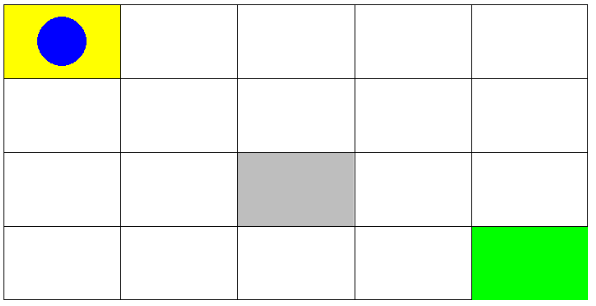

* ### Come es 1, ma viene aggiunta una cella “piena” che l’agente non può visitare
* ### Vengono anche aggiunte le azioni di movimento diagonale: “NE”, “NW”, “SE”, “SW”

### A) Risolvere con un agente razionale utility-based
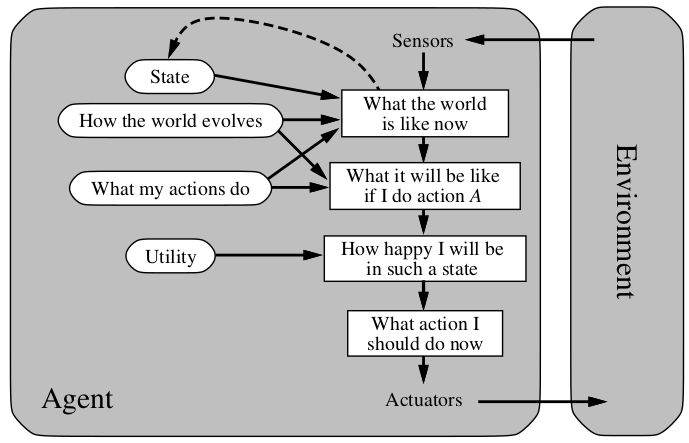

In [7]:
import math
es4_action_space = ["N", "S", "E", "W", "NE", "NW", "SE", "SW"]

# Note:
# - state è un dict che contiene:
#   - la posizione dell'agente in "x" e "y"
#   - la posizione del goal: "x_max" e "y_max"
def utility(state):
    # da completare: assegnare un valore di utility a state
    return -math.sqrt(pow(state['x']-state['x_max'], 2)+pow(state['y']-state['y_max'], 2))

# Note:
# - model è una funzione tale che model(state, action) ritorna un nuovo
#   dict next_state contenente lo stato a cui si arriva partendo da
#   state ed eseguendo action
def utility_based_action(state, model):
    # da completare: utilizzare model e la funzione utility definita
    # sopra per decidere l'azione migliore (i.e. che arriva in uno stato
    # a utility maggiore)
    
    max = 1
    best_action = None
    for a in es4_action_space:
        temp = utility(model(state, a))
        if temp > max:
            max = temp
            best_action = a
    
    return best_action


In [8]:
env = GridWorld(
    x_max=4,
    y_max=3,
    x_gray=2,
    y_gray=2,
    x_green=4,
    y_green=3,
    agent=None,
    omniscent=True,
    forbidden=[]
)
def m(s, a):
    x, y = env.model(s, a)
    s1 = s.copy()
    s1["x"] = x
    s1["y"] = y
    return s1
env.agent = lambda x, y, x_max, y_max: utility_based_action({"x": x, "y": y, "x_max": x_max, "y_max": y_max}, m)
print(f'Running es 4...')
run_env(env)

Running es 4...


2024-04-10 13:17:31.752 Python[1177:1907098] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


[env] received action: SE, agent position was: (0, 0)
[env] received action: E, agent position was: (1, 1)
[env] received action: SE, agent position was: (2, 1)
[env] received action: SE, agent position was: (3, 2)
[env] received action: S, agent position was: (4, 3)
The agent reached the goal successfully!


: 

### B) Nel caso in cui non siano disponibili le azioni di movimento diagonale, sarebbe comunque possibile risolvere il task per tutte le possibili configurazioni dell’ostacolo?
### Motivare la risposta

## **Esercizio 4**:
### Agente goal-based
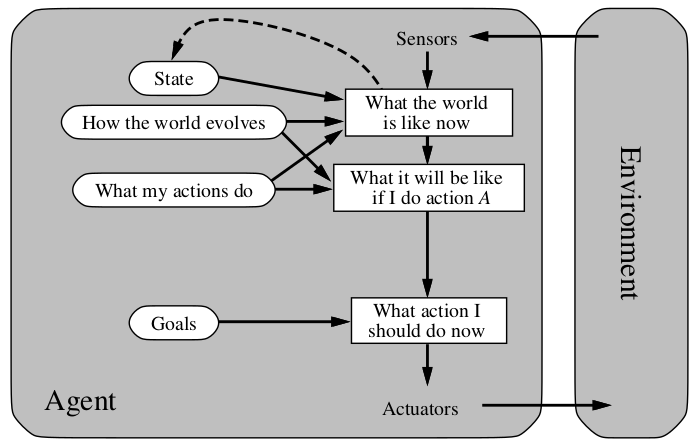
### Quale dei 4 tipi di agente è più adatto al caso in cui si voglia passare per una cella intermedia prima di raggiungere il goal?
### Motivare la risposta
